# 4 - Attention-based models:


In this notebook, we will see the implementation details of attention-based model, which is based on popular Transformer model from [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. Some of material are taken from [1](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [2](https://jalammar.github.io/illustrated-transformer/) [3](http://nlp.seas.harvard.edu/2018/04/03/attention.html),[4](https://github.com/bentrevett/pytorch-seq2seq) articles.

<!-- ![width=0.5](./transformer1.png) -->
<div>
<img src="transformer1.png" width="500"/>
</div>

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalizations. 

Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks. One of the most popular Transformer variants is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. A common library used when dealing with pre-trained transformers is the Hugging face [Transformers](https://huggingface.co/docs/transformers) library which we will take a deeper look into it in the next tutorial.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

In this exercise, we will ask you to implement some parts of the model including the Multi-head Attention mechansim, the Encoder Layer and the Decoder Layer. We will evaluate our model on the same German-English translation task as the previous tutorial. 

# Python3 environment requirements
This notebook was tested with Python 3.11.4 and the following library versions:
* torch==2.1.0
* torchtext==0.16.0
* spacy==3.5.3
* numpy==1.24.3
* portalocker>=2.0.0

In [1]:
!pip install -U torchtext portalocker>=2.0.0

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [2]:
import os
import torch
import random
import getpass
import numpy as np

def seed(seed = 1810):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# set seed for reproducibility
SEED = 1810
seed(SEED)

Now, we will download the tokenizers for each language. 

In [3]:
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.3 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 86.7 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.datasets import Multi30k
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

We'll then create our tokenizers as before.

In [5]:
src_tokenizer = get_tokenizer('spacy','de_core_news_sm' )
tgt_tokenizer = get_tokenizer('spacy','en_core_web_sm' )

We then load the Multi30k dataset and build the vocabulary.

In [6]:
from torchtext.data.functional import to_map_style_dataset

train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'))
train_list, valid_list = to_map_style_dataset(train_iter), to_map_style_dataset(valid_iter)
#The file for the test set is corrupted. For now we would take a fraction of validation set as our test test. 
valid_list = valid_list[-500:]
test_list = valid_list[:500]

In [7]:
def transformed(fn, index, data):
    #create a generator for either source or target sentences
    for line in data:
        yield fn(line[index])

src_vocab = build_vocab_from_iterator(transformed(src_tokenizer, 0, train_iter), specials=('<pad>', '<unk>', '<sos>', '<eos>'), min_freq=2)
tgt_vocab = build_vocab_from_iterator(transformed(tgt_tokenizer, 1, train_iter), specials=('<pad>', '<unk>', '<sos>', '<eos>'), min_freq=2)
src_vocab.set_default_index(src_vocab['<unk>'])
tgt_vocab.set_default_index(tgt_vocab['<unk>'])

/opt/conda/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Finally, we define the device and the data iterator.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
#transform each sentence into a sequence of token_ids  
def text_transform(sentence, vocab, tokenizer):
    return [vocab['<sos>']] + [vocab[token] for token in tokenizer(sentence)] + [vocab['<eos>']]

#prepare a batch for the model (i.e., transform the sequences into token_ids and pad them to have similar lengths)
def collate_batch(batch):
   src_list, tgt_list = [], []
   for (_src, _tgt) in batch:
        src_list.append(torch.tensor(text_transform(_src, src_vocab, src_tokenizer), device=device))
        tgt_list.append(torch.tensor(text_transform(_tgt, tgt_vocab, tgt_tokenizer), device=device))
   return pad_sequence(src_list, batch_first=True), pad_sequence(tgt_list, batch_first=True)

#group sequences with similar lenghts together
def batch_sampler(iterator):
    indices = [(i, len(src_tokenizer(s[0]))) for i, s in enumerate(iterator)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths 
    for i in range(0, len(indices), BATCH_SIZE * 100):
        pooled_indices.extend(sorted(indices[i:i + BATCH_SIZE * 100], key=lambda x: x[1]))

    pooled_indices = [x[0] for x in pooled_indices]

    # create indices for current batch
    batch_indices = []
    for i in range(0, len(pooled_indices), BATCH_SIZE):
        batch_indices.append(pooled_indices[i:i + BATCH_SIZE])
    return batch_indices


BATCH_SIZE = 8  # A batch size of 8

train_dataloader, valid_dataloader, test_dataloader = [DataLoader(iterator, batch_sampler=batch_sampler(iterator),
                               collate_fn=collate_batch) for iterator in [train_list, valid_list, test_list]]

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence is 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

<div align="center">
<img src="transformer-encoder.png" width="200"/>
</div>

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrence it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use learnable positional embeddings instead, hence we have decided to use them in this tutorial. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which can be used by the decoder.

The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 otherwise. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.

In [10]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Part 1: Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the *multi-head attention layer*, then perform dropout on it, apply a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer. We then pass it through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers. 

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self-attention*.

[This](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) article goes into more details about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

We would like you to implement the forward function of the encoder layer according to the descriptions. You can also consider the illustration of an Encoder Layer in Figure 1, but note that the dropout layers are not shown there. 

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        src_enc = None 
        ### BEGIN SOLUTION
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src_enc = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src_enc)
        
        #dropout, residual and layer norm
        src_enc = self.ff_layer_norm(src_enc + self.dropout(_src))
        ### END SOLUTION
        
        #src_enc = [batch size, src len, hid dim]
        
        return src_enc

### Part 2: Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

<div>
<img src="attention.png" width="700"/>
</div>

Attention can be thought of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $\sqrt{d_k}$ before finally then multiplying by the value. ${d_k}$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `logits` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the logits so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

We would like you to implement the forward function of this module and compute the final output of it. Note that you should apply dropout layer on top of the attention weights. 

In [12]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        #TODO: compute Q, K, V per head 
        Q = None
        K = None
        V = None
        
        ### BEGIN SOLUTION
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        ### END SOLUTION
        
        #TODO: compute the logits (un-normalized attention weights) and apply src_mask
        logits = None
        
        ###BEGIN SOLUTION
        logits = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            logits = logits.masked_fill(mask == 0, -1e10)
        ###END SOLUTION
        
        attention = torch.softmax(logits, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        
        #compute the output
        out = None
        ###BEGIN SOLUTION
        out = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        out = out.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        out = out.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        out = self.fc_o(out)
        
        #out = [batch size, query len, hid dim]
        ###END SOLUTION
        
        return out, attention

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the [GELU](https://arxiv.org/abs/1606.08415) activation function, which can be used by simply switching `torch.relu` for `F.gelu`. Why did they use GELU? Again, it is never explained.

In [13]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

<div align="center">
  <img src="transformer-decoder.png" width="200"/>
</div>

The decoder is similar to encoder, however it now has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer over the source context, which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines them - via an elementwise sum - with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, `fc_out`. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

As well as using the source mask, as we did in the encoder to prevent our model attending to `<pad>` tokens, we also use a target mask. This will be explained further in the `Seq2Seq` model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it. 

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [14]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Part 3: Decoder Layer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This `self_attention` layer uses the target sequence mask, `trg_mask`, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, `enc_src`, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the encoder representations. Here, the source mask, `src_mask` is used to prevent the multi-head attention layer from attending to `<pad>` tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers. 

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

We would like you to implement the forward function of this module given the descriptions. 

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        attention = None #TODO: implement me (attention of Decoder over encoded source sequence)
        
        out = None #implement me
        
        ###BEGIN SOLUTION
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        out = self.ff_layer_norm(trg + self.dropout(_trg))
        ###END SOLUTION
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return out, attention

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `logits`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they are used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [17]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(tgt_vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [18]:
SRC_PAD_IDX = src_vocab['<pad>']
TRG_PAD_IDX = tgt_vocab['<pad>']

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [19]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [20]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [21]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [22]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [23]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch[0]
        trg = batch[1]
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator.dataset)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [24]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0]
            trg = batch[1]

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator.dataset)

We then define a small function that we can use to tell us how long an epoch takes.

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. 
<!-- This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity! -->

In [26]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 24m 51s
	Train Loss: 0.460 | Train PPL:   1.585
	 Val. Loss: 0.405 |  Val. PPL:   1.499
Epoch: 02 | Time: 25m 14s
	Train Loss: 0.377 | Train PPL:   1.458
	 Val. Loss: 0.370 |  Val. PPL:   1.448
Epoch: 03 | Time: 25m 48s
	Train Loss: 0.343 | Train PPL:   1.409
	 Val. Loss: 0.357 |  Val. PPL:   1.428
Epoch: 04 | Time: 24m 57s
	Train Loss: 0.319 | Train PPL:   1.376
	 Val. Loss: 0.344 |  Val. PPL:   1.410
Epoch: 05 | Time: 25m 5s
	Train Loss: 0.303 | Train PPL:   1.353
	 Val. Loss: 0.342 |  Val. PPL:   1.408
Epoch: 06 | Time: 25m 44s
	Train Loss: 0.289 | Train PPL:   1.335
	 Val. Loss: 0.337 |  Val. PPL:   1.400
Epoch: 07 | Time: 25m 49s
	Train Loss: 0.278 | Train PPL:   1.320
	 Val. Loss: 0.337 |  Val. PPL:   1.400
Epoch: 08 | Time: 26m 27s
	Train Loss: 0.268 | Train PPL:   1.308
	 Val. Loss: 0.334 |  Val. PPL:   1.396
Epoch: 09 | Time: 26m 26s
	Train Loss: 0.259 | Train PPL:   1.296
	 Val. Loss: 0.333 |  Val. PPL:   1.395
Epoch: 10 | Time: 26m 5s
	Train Loss: 0.251 | T

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [27]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.333 | Test PPL:   1.395 |


##### Analysis
Compare the Transformer model results with the sequence-to-sequence model you implemented in the previous assignment. What do you think are the advantages of the Transformer model over the previous model? What are the disadvantages?

## Inference

Now we can use translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [28]:
def translate_sentence(sentence, src_vocab, tgt_vocab, src_tokenizer, model, device, max_len = 50):
    
    model.eval()
        
    src_indexes = text_transform(sentence, src_vocab, src_tokenizer) #[src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [tgt_vocab['<sos>']]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == tgt_vocab['<eos>']:
            break
    
    trg_tokens =tgt_vocab.lookup_tokens(trg_indexes) #[tgt_vocab.get_itos(i) for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads we can view the attention for each of the heads.

In [29]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [30]:
example_idx = 8

src = train_dataloader.dataset[example_idx][0]
trg = train_dataloader.dataset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = Eine Frau mit einer großen Geldbörse geht an einem Tor vorbei.
trg = A woman with a large purse is walking by a gate.


Now we can see how our model translates the source sentence in comparison to the target sequence. 

In [31]:
translation, attention = translate_sentence(src, src_vocab, tgt_vocab, src_tokenizer , model, device)

print(f'predicted trg = {translation}')

predicted trg = ['A', 'woman', 'in', 'a', 'headscarf', 'is', 'walking', 'through', 'a', 'plaza', '.', '<eos>']


We can see the attention from each head below.

/tmp/ipykernel_387/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_387/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


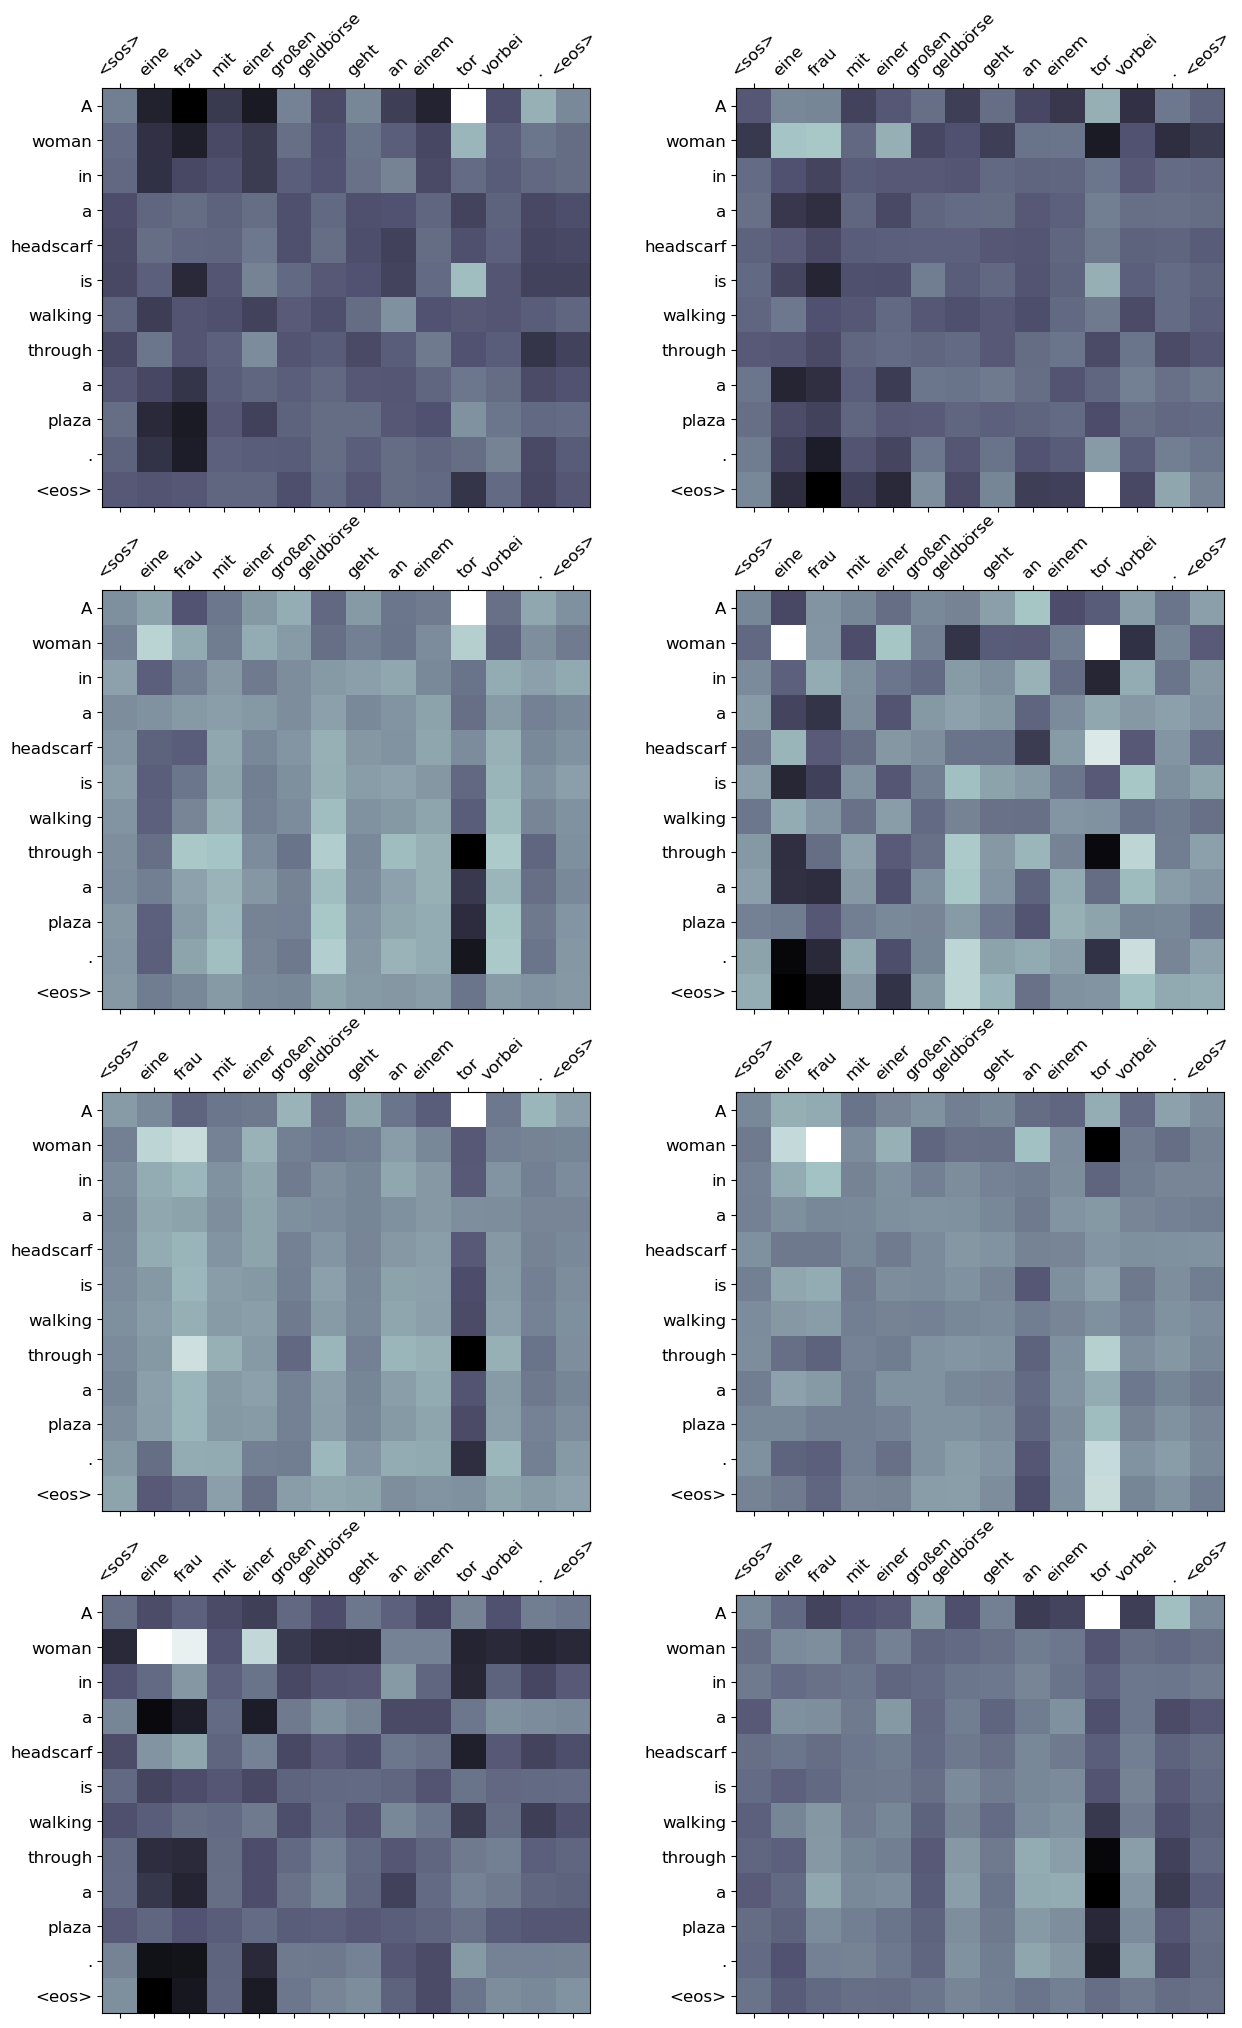

In [32]:
display_attention(src_tokenizer(src), translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [33]:
example_idx = 6

src = valid_dataloader.dataset[example_idx][0]
trg = valid_dataloader.dataset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = Ein großer Hund springt in einem Springbrunnen herum, während ein Mann mit einem schwarzen T-Shirt und einer Weste danebensteht.
trg = A large dog is jumping in a fountain while a man in a black T-shirt and vest stands nearby.


Now we can see how our model translates the source sentence. 

In [34]:
translation, attention = translate_sentence(src, src_vocab, tgt_vocab, src_tokenizer , model, device)

print(f'predicted trg = {translation}')

predicted trg = ['A', 'dog', 'in', 'a', 'blue', 'vest', 'and', 'blue', 'hat', 'is', 'running', 'through', 'a', 'pool', '.', '<eos>']


And look at the attention maps of each head. 

/tmp/ipykernel_387/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_387/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


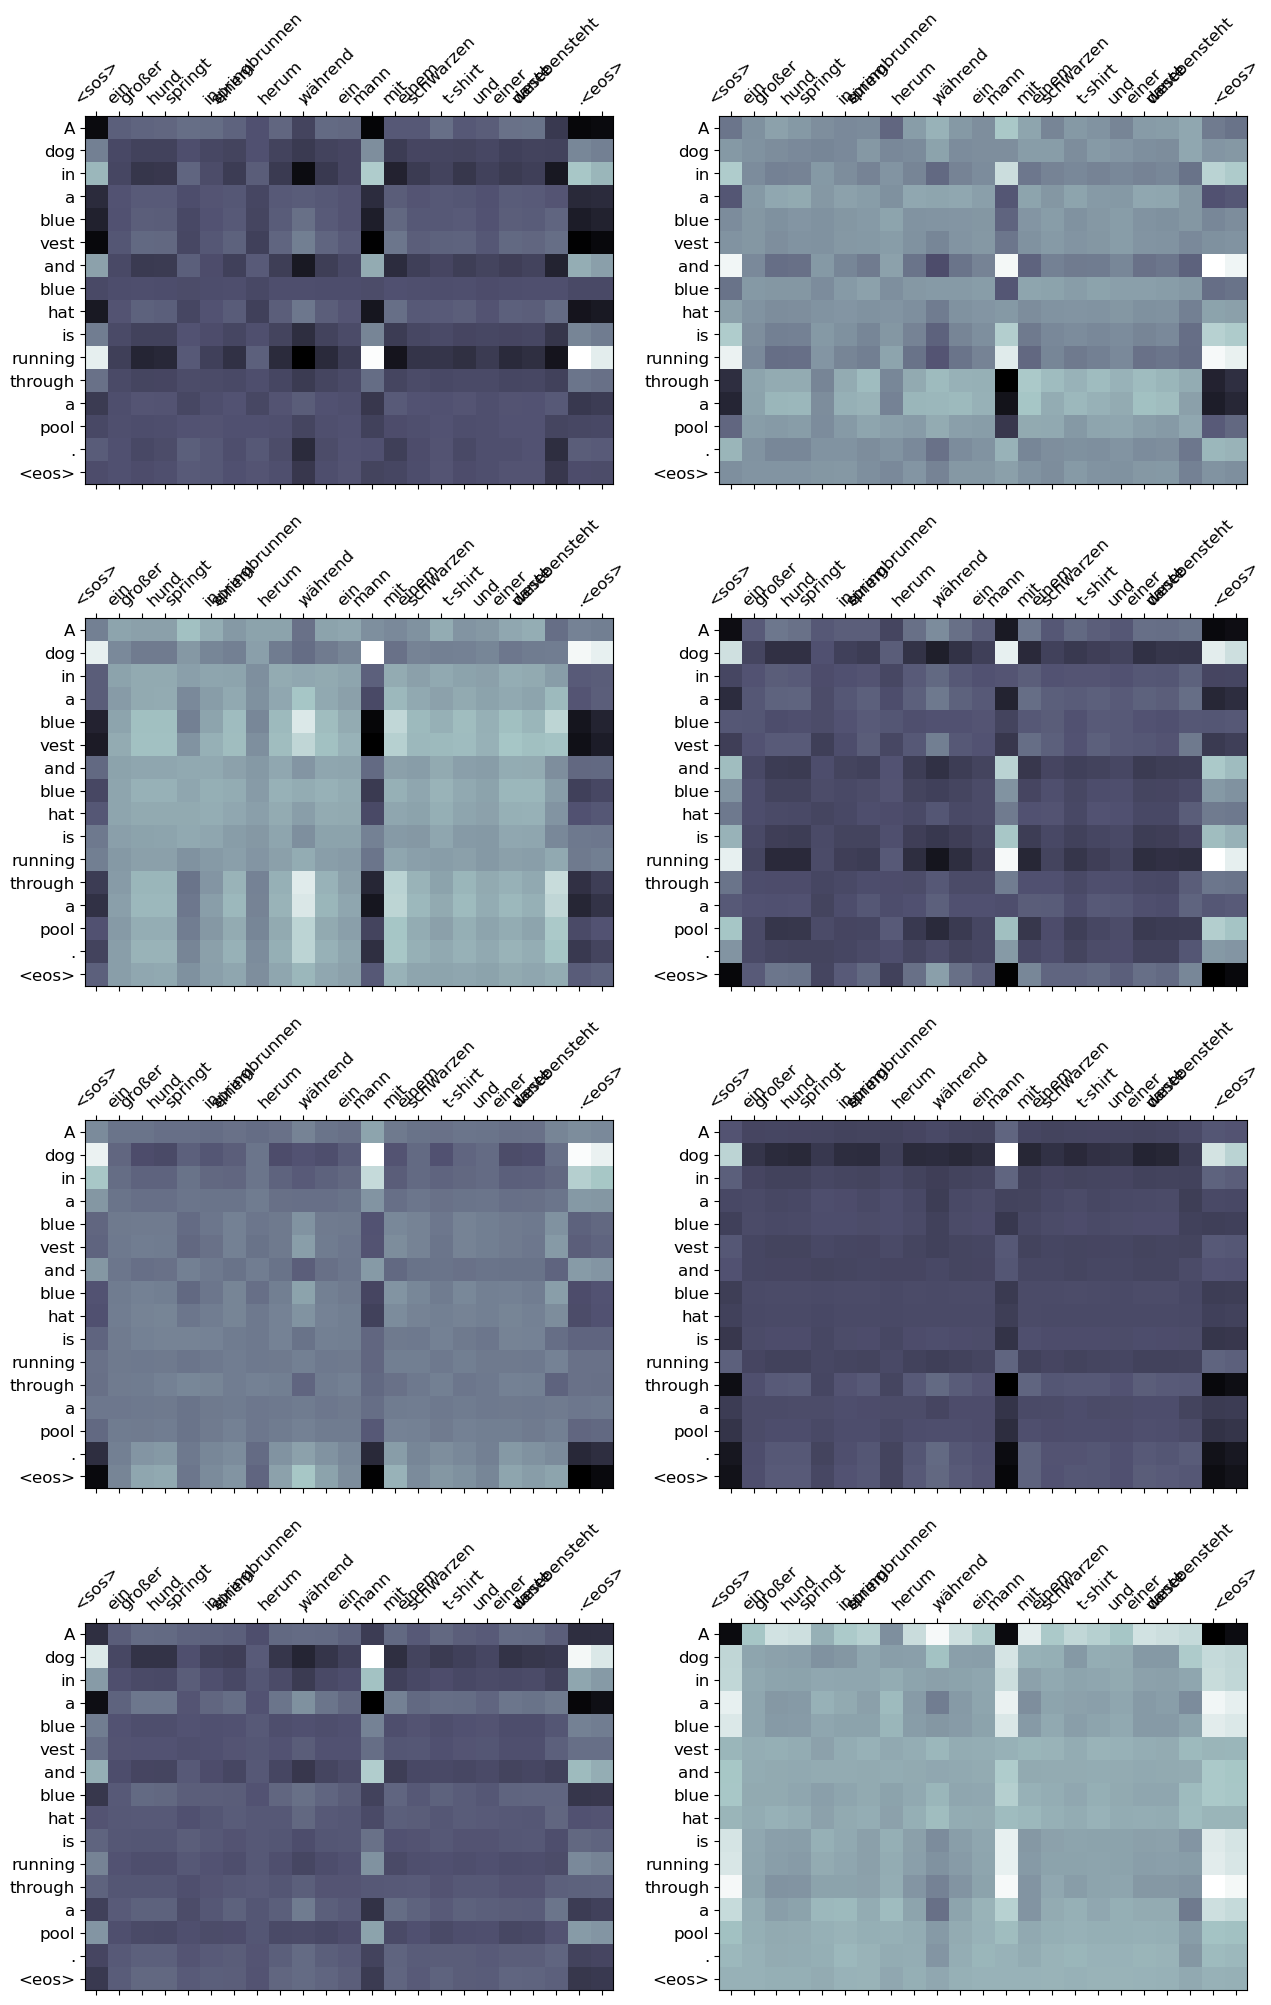

In [35]:
display_attention(src_tokenizer(src), translation, attention)

Finally, we'll look at an example from the test data.

In [36]:
example_idx = 10

src = test_dataloader.dataset[example_idx][0]
trg = test_dataloader.dataset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = Ein Verkäufer sitzt inmitten seines Brillensortiments auf einem Straßenmarkt in einem asiatischen Land.
trg = A vendor sits in the middle of a display of glasses at a street market in an Asian country.


We can then see the translation and attention maps of our model. 

In [37]:
translation, attention = translate_sentence(src, src_vocab, tgt_vocab, src_tokenizer , model, device)

print(f'predicted trg = {translation}')

predicted trg = ['A', 'street', 'vendor', 'is', 'standing', 'on', 'the', 'street', '.', '<eos>']


/tmp/ipykernel_387/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_387/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


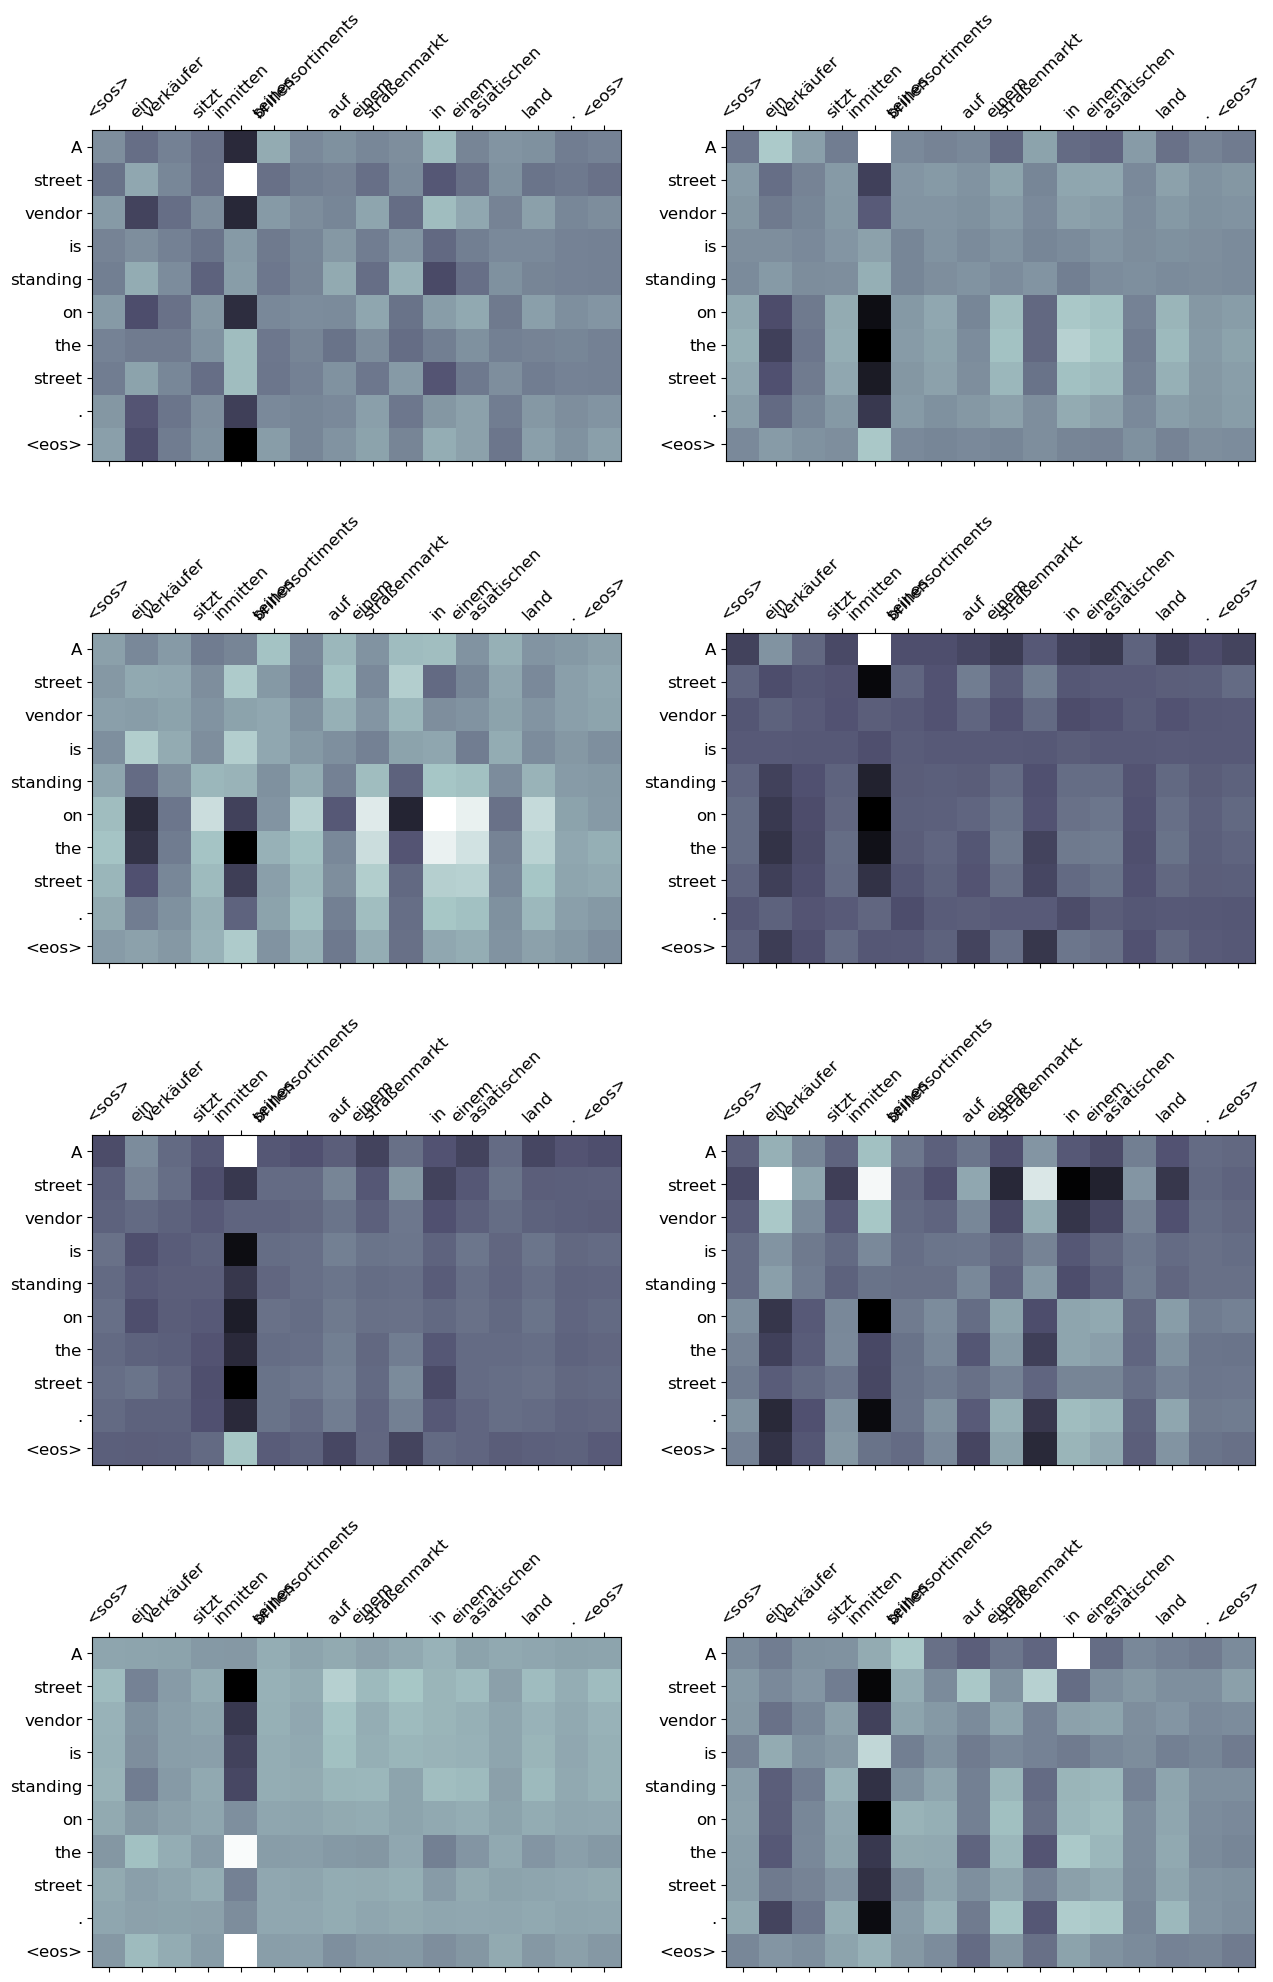

In [38]:
display_attention(src_tokenizer(src), translation, attention)

##### Analysis
Where does the model make mistakes? What do you think we can do to improve its performance? 